In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [2]:
import torchvision.transforms as transforms

In [4]:
import torch.nn.functional as F

In [3]:
seed = 42
torch.manual_seed(seed)
#torch.backends.cudnn.benchmark = False
#torch.backends.cudnn.deterministic = True

Let's define our dataloaders 

In [204]:
latent_dim = 10

In [121]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        #transforms.Normalize((0.5,), (0.5,))
    ]
)


In [155]:
trainset = torchvision.datasets.MNIST(
    root = './data/', 
    train = True, 
    download = True, 
    transform = transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size = 100, 
    shuffle = True, 
    num_workers = 2
)


testset = torchvision.datasets.MNIST(
    root = './data',
    train = False, 
    download = True, 
    transform = transform 
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size = 100, 
    shuffle = False, 
    num_workers = 2
)

In [156]:
classes = (
    np.arange(10)
)

    0    1    7    5


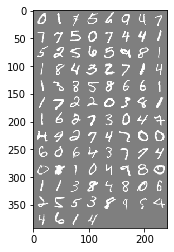

In [157]:
def imshow(img): 
    img = img/2 + 0.5 # unnormalize 
    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
# Get some random training images    
dataiter = iter(trainloader)

images, labels = dataiter.next()

# show images 

imshow(torchvision.utils.make_grid(images))

print(''.join('%5s' % classes[labels[j]] for j in range(4)))

In [126]:
im = images[0]

In [129]:
im.numpy().max()

0.99607843

In [130]:
im.numpy().min()

0.0

Let's define our basic autoencoder, with two hidden layers. 

In [205]:
class AE(nn.Module): 
    
    def __init__(self, **kwargs): 
        super().__init__()
        
        #image_shape = kwargs['input_shape']
        
        self.encoder = nn.Sequential(
            
            # Input channels, output channels, size of conv filter 5x5
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_dim)

        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            # Final activation to return to [-1, 1 ] range
            nn.Sigmoid()
        )
        
    def encode(self, x): 
        return self.encoder(x)
    
    def decode(self, x): 
        return self.decoder(x)
    
    def forward(self, x): 
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x
    


In [206]:
autoencoder = AE()

In [207]:
loss_function = nn.BCELoss()

optimizer = optim.Adam(autoencoder.parameters(), lr = 1e-3)

Let's train and generate some images. 

In [208]:
batch_size = 100

In [223]:
def init_network_weights(net): 
    
    
    torch.manual_seed(42)
    
    for m in net.modules():
        torch.manual_seed(42)
        if isinstance(m, nn.Linear): 
            nn.init.xavier_normal_(m.weight)
            nn.init.uniform_(m.bias)
            
    return net
    
    

In [224]:
autoencoder = init_network_weights(autoencoder)

In [225]:
for epoch in np.arange(2): 
    
    running_loss = 0.0
    
    # Batch training 
    for ix, data in enumerate(tqdm.tqdm(trainloader)): 
        
        inputs, labels = data
        
        #print(inputs.size()[0])
        
        #Flatten batch of images before feeding 
        # input dims are (batch_size, 784)
        input_ = inputs.view(batch_size, -1)
        
        #print(input_.size())
        
        # zero-out parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize 
        outputs = autoencoder(input_)
        
        #print('out_size', outputs.size())
        
        # Compute error
        error = loss_function(outputs, input_)
        
        # Backprop error
        error.backward()
        
        # Update weights 
        optimizer.step()
        
        running_loss += error.item()
        
        if ix % 200 == 199: # print every 200 mini-batches
            
            # Slightly awkward print statement 
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, ix+1, running_loss / 200))
            
            # Reinitialize loss per minibatch 
            running_loss = 0.0

print('Finished training')





  0%|          | 0/600 [00:00<?, ?it/s]



  0%|          | 1/600 [00:00<02:01,  4.92it/s]



  1%|          | 4/600 [00:00<01:30,  6.56it/s]



  2%|▏         | 11/600 [00:00<01:05,  8.94it/s]



  2%|▏         | 14/600 [00:00<00:51, 11.28it/s]



  3%|▎         | 18/600 [00:00<00:40, 14.31it/s]



  4%|▎         | 21/600 [00:00<00:35, 16.10it/s]



  4%|▍         | 25/600 [00:00<00:31, 18.45it/s]



  5%|▍         | 29/600 [00:01<00:26, 21.73it/s]



  6%|▌         | 36/600 [00:01<00:20, 27.09it/s]



  7%|▋         | 42/600 [00:01<00:17, 32.19it/s]



  8%|▊         | 49/600 [00:01<00:14, 37.99it/s]



  9%|▉         | 55/600 [00:01<00:13, 39.40it/s]



 10%|█         | 61/600 [00:01<00:12, 43.54it/s]



 11%|█         | 67/600 [00:01<00:11, 46.42it/s]



 12%|█▏        | 73/600 [00:01<00:11, 45.22it/s]



 13%|█▎        | 79/600 [00:01<00:10, 48.41it/s]



 14%|█▍        | 85/600 [00:02<00:10, 49.94it/s]



 15%|█▌        | 92/600 [00:02<00:09, 53.90it/s]



 16%|█▋        | 99

[1,   200] loss: 0.233






 36%|███▋      | 219/600 [00:04<00:05, 71.46it/s]



 38%|███▊      | 228/600 [00:04<00:04, 74.85it/s]



 39%|███▉      | 236/600 [00:04<00:04, 74.93it/s]



 41%|████      | 244/600 [00:04<00:04, 75.48it/s]



 42%|████▏     | 252/600 [00:04<00:04, 74.00it/s]



 43%|████▎     | 260/600 [00:04<00:04, 75.63it/s]



 45%|████▍     | 268/600 [00:04<00:04, 74.49it/s]



 46%|████▌     | 276/600 [00:04<00:04, 73.51it/s]



 47%|████▋     | 284/600 [00:04<00:04, 74.57it/s]



 49%|████▊     | 292/600 [00:05<00:04, 73.64it/s]



 50%|█████     | 300/600 [00:05<00:04, 74.33it/s]



 51%|█████▏    | 308/600 [00:05<00:03, 74.50it/s]



 53%|█████▎    | 316/600 [00:05<00:03, 75.60it/s]



 54%|█████▍    | 324/600 [00:05<00:03, 76.13it/s]



 55%|█████▌    | 332/600 [00:05<00:03, 75.65it/s]



 57%|█████▋    | 340/600 [00:05<00:03, 74.60it/s]



 58%|█████▊    | 348/600 [00:05<00:03, 70.95it/s]



 59%|█████▉    | 356/600 [00:05<00:03, 70.63it/s]



 61%|██████    | 364/600 [00:06<00:03, 70.

[1,   400] loss: 0.158






 70%|███████   | 421/600 [00:06<00:02, 73.33it/s]



 72%|███████▏  | 429/600 [00:06<00:02, 73.67it/s]



 73%|███████▎  | 437/600 [00:07<00:02, 74.62it/s]



 74%|███████▍  | 445/600 [00:07<00:02, 75.09it/s]



 76%|███████▌  | 453/600 [00:07<00:01, 73.66it/s]



 77%|███████▋  | 461/600 [00:07<00:02, 68.21it/s]



 78%|███████▊  | 469/600 [00:07<00:01, 70.21it/s]



 80%|███████▉  | 477/600 [00:07<00:01, 72.81it/s]



 81%|████████  | 485/600 [00:07<00:01, 73.87it/s]



 82%|████████▏ | 493/600 [00:07<00:01, 74.23it/s]



 84%|████████▎ | 501/600 [00:07<00:01, 74.72it/s]



 85%|████████▍ | 509/600 [00:08<00:01, 76.20it/s]



 86%|████████▌ | 517/600 [00:08<00:01, 77.16it/s]



 88%|████████▊ | 526/600 [00:08<00:00, 78.72it/s]



 89%|████████▉ | 534/600 [00:08<00:00, 77.27it/s]



 90%|█████████ | 542/600 [00:08<00:00, 76.83it/s]



 92%|█████████▏| 550/600 [00:08<00:00, 75.23it/s]



 93%|█████████▎| 558/600 [00:08<00:00, 75.73it/s]



 94%|█████████▍| 566/600 [00:08<00:00, 74.

[1,   600] loss: 0.146






  0%|          | 1/600 [00:00<01:31,  6.57it/s]



  1%|▏         | 8/600 [00:00<01:05,  9.01it/s]



  2%|▏         | 11/600 [00:00<00:52, 11.13it/s]



  3%|▎         | 19/600 [00:00<00:38, 14.92it/s]



  4%|▍         | 27/600 [00:00<00:29, 19.54it/s]



  6%|▌         | 34/600 [00:00<00:23, 24.44it/s]



  7%|▋         | 40/600 [00:00<00:20, 27.82it/s]



  8%|▊         | 45/600 [00:01<00:18, 30.08it/s]



  8%|▊         | 50/600 [00:01<00:19, 27.75it/s]



  9%|▉         | 54/600 [00:01<00:17, 30.50it/s]



 10%|█         | 61/600 [00:01<00:14, 36.39it/s]



 12%|█▏        | 69/600 [00:01<00:12, 42.86it/s]



 12%|█▎        | 75/600 [00:01<00:11, 45.79it/s]



 14%|█▎        | 82/600 [00:01<00:10, 50.87it/s]



 15%|█▍        | 88/600 [00:01<00:09, 51.26it/s]



 16%|█▌        | 94/600 [00:01<00:09, 52.44it/s]



 17%|█▋        | 100/600 [00:02<00:09, 53.63it/s]



 18%|█▊        | 107/600 [00:02<00:08, 55.02it/s]



 19%|█▉        | 113/600 [00:02<00:09, 53.38it/s]



 20%|█▉

[2,   200] loss: 0.140






 36%|███▌      | 215/600 [00:03<00:06, 57.46it/s]



 37%|███▋      | 221/600 [00:04<00:07, 50.36it/s]



 38%|███▊      | 227/600 [00:04<00:07, 52.53it/s]



 39%|███▉      | 234/600 [00:04<00:06, 56.04it/s]



 40%|████      | 241/600 [00:04<00:06, 58.40it/s]



 41%|████      | 247/600 [00:04<00:06, 55.95it/s]



 42%|████▏     | 254/600 [00:04<00:05, 58.09it/s]



 44%|████▎     | 262/600 [00:04<00:05, 61.71it/s]



 45%|████▌     | 270/600 [00:04<00:05, 65.87it/s]



 46%|████▋     | 278/600 [00:04<00:04, 68.93it/s]



 48%|████▊     | 286/600 [00:05<00:04, 69.93it/s]



 49%|████▉     | 294/600 [00:05<00:04, 70.47it/s]



 50%|█████     | 302/600 [00:05<00:04, 71.23it/s]



 52%|█████▏    | 310/600 [00:05<00:05, 57.61it/s]



 53%|█████▎    | 317/600 [00:05<00:05, 49.11it/s]



 54%|█████▍    | 323/600 [00:05<00:06, 42.76it/s]



 55%|█████▍    | 328/600 [00:05<00:07, 38.59it/s]



 56%|█████▌    | 333/600 [00:06<00:08, 29.90it/s]



 57%|█████▋    | 341/600 [00:06<00:07, 36.

[2,   400] loss: 0.136






 69%|██████▉   | 415/600 [00:07<00:03, 55.72it/s]



 70%|███████   | 422/600 [00:07<00:03, 58.52it/s]



 71%|███████▏  | 428/600 [00:07<00:02, 57.99it/s]



 72%|███████▏  | 434/600 [00:07<00:02, 57.21it/s]



 74%|███████▎  | 442/600 [00:08<00:02, 61.14it/s]



 75%|███████▌  | 450/600 [00:08<00:02, 64.85it/s]



 76%|███████▌  | 457/600 [00:08<00:02, 66.31it/s]



 78%|███████▊  | 465/600 [00:08<00:01, 68.07it/s]



 79%|███████▊  | 472/600 [00:08<00:01, 68.37it/s]



 80%|████████  | 480/600 [00:08<00:01, 69.78it/s]



 81%|████████▏ | 488/600 [00:08<00:01, 71.66it/s]



 83%|████████▎ | 496/600 [00:08<00:01, 73.73it/s]



 84%|████████▍ | 504/600 [00:08<00:01, 75.14it/s]



 85%|████████▌ | 512/600 [00:08<00:01, 75.67it/s]



 87%|████████▋ | 520/600 [00:09<00:01, 74.36it/s]



 88%|████████▊ | 528/600 [00:09<00:00, 74.03it/s]



 89%|████████▉ | 536/600 [00:09<00:00, 73.62it/s]



 91%|█████████ | 544/600 [00:09<00:00, 74.89it/s]



 92%|█████████▏| 552/600 [00:09<00:00, 74.

[2,   600] loss: 0.135
Finished training


We can see that in general, the loss doesn't decrease that much when using MSE. Let's try optimizing binary cross entropy. 

In [226]:
data = []
labels_ = []

for batch_x, label in tqdm.tqdm(testloader): 
    batch_x = batch_x.view(-1, 784)
    batch_x_preds = autoencoder.encode(batch_x).detach().numpy()
    
    targets = label.detach().numpy()
    
    for x, y in zip(batch_x_preds, targets):
        
        #print('xshape: ', x.shape)
        data.append(x.reshape(latent_dim))
        
        labels_.append(y)
        





  0%|          | 0/100 [00:00<?, ?it/s]



  1%|          | 1/100 [00:00<00:16,  6.11it/s]



  9%|▉         | 9/100 [00:00<00:10,  8.43it/s]



 19%|█▉        | 19/100 [00:00<00:06, 11.59it/s]



 27%|██▋       | 27/100 [00:00<00:04, 15.44it/s]



 35%|███▌      | 35/100 [00:00<00:03, 20.26it/s]



 45%|████▌     | 45/100 [00:00<00:02, 26.48it/s]



 55%|█████▌    | 55/100 [00:00<00:01, 33.55it/s]



 65%|██████▌   | 65/100 [00:00<00:00, 41.50it/s]



 75%|███████▌  | 75/100 [00:01<00:00, 49.30it/s]



 84%|████████▍ | 84/100 [00:01<00:00, 54.35it/s]



 92%|█████████▏| 92/100 [00:01<00:00, 60.08it/s]



100%|██████████| 100/100 [00:01<00:00, 71.53it/s]


In [227]:
len(data)

10000

In [228]:
data_ = np.array(data)

In [229]:
latent_umap = UMAP(random_state = 42).fit_transform(data_)

/Users/manoloflores/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


In [230]:
df_umap = pd.DataFrame(latent_umap, columns = ['u1', 'u2'])

In [231]:
labels_[0]

7

In [232]:
df_umap['labels'] = labels_

In [233]:
df_umap.head()

,u1,u2,labels
0,0.162683,6.787424,7
1,-0.607549,0.347805,2
2,-11.404963,0.936635,1
3,2.928166,-5.723740,0
4,5.175035,6.758492,4


In [234]:
df_umap.hvplot.scatter(
    x = 'u1', 
    y = 'u2', 
    c = 'labels', 
    alpha = 0.2, 
    padding = 0.2, 
    cmap = 'Set2'
)

:Scatter   [u1]   (u2,labels)

In [235]:
df_umap['z1'], df_umap['z2'], df_umap['z3'] = data_[:, :3].T

In [236]:
df_umap.hvplot.scatter(
    x = 'z1', 
    y = ['z2', 'z3'], 
    c = 'labels', 
    alpha = 0.2, 
    padding = 0.2, 
    cmap = 'Accent', 
    subplots = True, 
    width = 400

).cols(1)

:NdLayout   [Variable]
   :Scatter   [z1]   (value,labels)